In [13]:
import numpy as np
import matplotlib.pyplot as plt

nz=101; nx=101; h=20

nt=500; dt=0.006
ntr=1

def read(filename,n=None):
    if n==None:
        nn=(nx,nz)
    else:
        nn=n
    return np.fromfile(filename,dtype='float32').reshape(nn).T

def read_su(filename):
    !sustrip < $filename > /home/wzhou/tmp outpar=outpar
    data=read('/home/wzhou/tmp',n=(ntr,nt))
    !rm /home/wzhou/tmp 
    return data

def imshow(data,perc=None,clip=None,clipmin=None,cmap='viridis',title=None,grid=True):
    
    if perc==None:
        clipp=[np.amin(data),np.amax(data)]
    else:
        tmp=np.percentile(np.abs(data),q=perc)
        clipp=[-tmp,tmp]
    
    if clip!=None: clipp=clip
    
    if clipmin!=None: clipp[0]=clipmin
    
    plt.imshow(data,vmin=clipp[0],vmax=clipp[1],cmap=cmap,aspect='auto')
    plt.colorbar(location='right')
    plt.grid(visible=grid, axis='both', which='both', color='w', linestyle='--',linewidth=0.5)
    #plt.xlabel(labels[0]); plt.ylabel(labels[1])
    if title!=None: plt.title(title)

## FWD

rm: cannot remove 'rho1': No such file or directory
rm: cannot remove 'rho2': No such file or directory


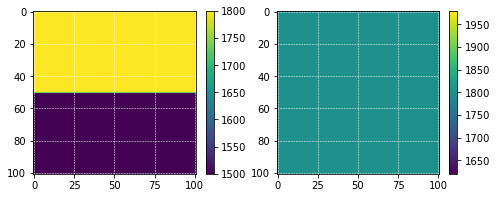

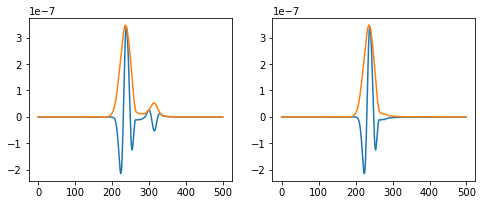

In [33]:
## with reflections
!makevel nz=51 nx=$nx v000=1800 > vp1
!makevel nz=50 nx=$nx v000=1500 > vp2
!cat vp1  vp2  > tmp1 && transp < tmp1 n1=$nx > model
!rm vp1 vp2 rho1 rho2 tmp*

## plot
plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(read('model'))

!../../exe/FWD setup.in > out_fwd

!rm -r results_fwd; mv results  results_fwd
!(cd results_fwd; suenv < dsyn_Shot0001.su > denv_Shot0001.su)

## w/o reflections
!makevel nz=$nz nx=$nx v000=1800 > model

!../../exe/FWD setup.in > out_fwd_norefl

!rm -r results_fwd_norefl; mv results  results_fwd_norefl
!(cd results_fwd_norefl; suenv < dsyn_Shot0001.su > denv_Shot0001.su)

## plot
plt.subplot(1,2,2); imshow(read('model'))

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(read_su('results_fwd/dsyn_Shot0001.su'))
plt.plot(read_su('results_fwd/denv_Shot0001.su'))

plt.subplot(1,2,2)
plt.plot(read_su('results_fwd_norefl/dsyn_Shot0001.su'))
plt.plot(read_su('results_fwd_norefl/denv_Shot0001.su'))

## PFEI estimate wavelet for envelope modeling

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


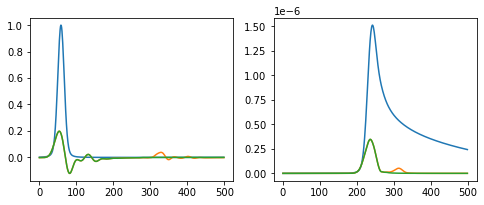

In [41]:
## w/o reflections
!makevel nz=$nz nx=$nx v000=1800 > model

!cp setup.in setup_wl.in
!echo "WAVELET_TYPE   'ricker envelope'" >> setup_wl.in
!echo "FILE_DATA_PREFIX    'results_fwd_norefl/denv_Shot'" >> setup_grad.in
!echo "JOB    'estimate wavelet'" >> setup_wl.in

!../../exe/PFEI setup_wl.in > out_wl
!rm -r results_wl; mv results results_wl
!(cd results_wl; sumute < updated_wavelet.su key=tracl xmute=1   ntaper=50 mode=1  tmute=1.8 > muted_updated_wavelet.su)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(read_su('results_wl/wavelet.su'))
plt.plot(read_su('results_wl/updated_wavelet.su'))
plt.plot(read_su('results_wl/muted_updated_wavelet.su'))
plt.subplot(1,2,2)
plt.plot(read_su('results_wl/RE0_Shot0001.su'))
plt.plot(read_su('results_wl/updated_RE0_Shot0001.su'))
plt.plot(read_su('results_fwd_norefl/denv_Shot0001.su'))

## PFEI gradient for tilD

In [51]:
## with reflections
!makevel nz=51 nx=$nx v000=1800 > vp1
!makevel nz=50 nx=$nx v000=1500 > vp2
!cat vp1  vp2  > tmp1 && transp < tmp1 n1=$nx > model
!rm vp1 vp2 rho1 rho2 tmp*

!makevel nz=1 nx=$nx v000=100 > topo
#makevel nz=1 nx=$nx v000=400 > topo

!cp setup.in setup_grad.in
!echo "FILE_WAVELET   './results_wl/muted_updated_wavelet.su'" >> setup_grad.in

!../../exe/PFEI setup_grad.in  > out_grad
!rm -r results_grad; mv results results_grad

rm: cannot remove 'rho1': No such file or directory
rm: cannot remove 'rho2': No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


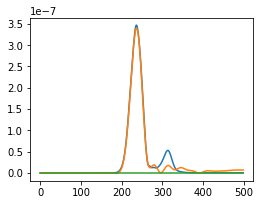

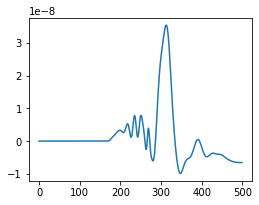

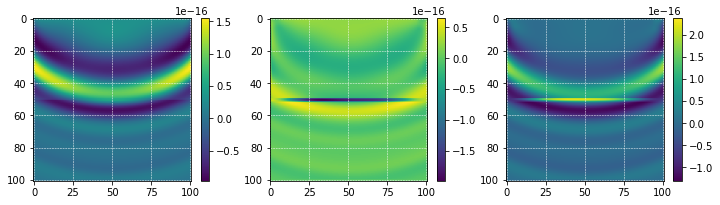

In [71]:
plt.figure(figsize=(4,3))
plt.plot(read_su('results_fwd/denv_Shot0001.su'))
plt.plot(read_su('results_grad/RE0_Shot0001.su'))
plt.plot(read_su('results_grad/RdE_Shot0001.su'))

plt.figure(figsize=(4,3))
plt.plot(read_su('results_grad/dadj_Shot0001.su'))

plt.figure(figsize=(12,3))
plt.subplot(1,3,1);imshow(read('results_grad/gtilD_dt2'))
plt.subplot(1,3,2);imshow(1800**2*read('results_grad/gtilD_nab2'))
plt.subplot(1,3,3);imshow(read('results_grad/gtilD'))

## GradientTest

In [79]:
!make

!cp setup.in setup_test.in
!echo "FILE_WAVELET   './results_wl/muted_updated_wavelet.su'" >> setup_test.in
!echo "JOB   'build tilD'" >> setup_test.in
!echo "ALPHAS 1e-5" >> setup_test.in
!echo "ARTIFICIAL_SCALER_ON_dE     1e-3" >> setup_test.in
artifical=1e-3

!rm -r results
!../../exe/GradientTest  setup_test.in > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

#System
(cd ../../Modules/System; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/System'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/System'
#Etc
(cd ../../Modules/Etc; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Etc'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Etc'
#Signal
(cd ../../Modules/Signal; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Signal'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Signal'
#Modeling
(cd ../../Modules/Modeling; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Modeling'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Modeling'
#Kernel
(cd ../../Modules/Kernel; make App=FWI)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Kernel'
m_parametrizer_vp2-tilD.f90 m_querypoint.f90 m_weighter.f90 m_preconditioner.f90 m_fo

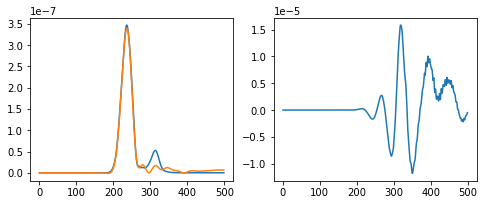

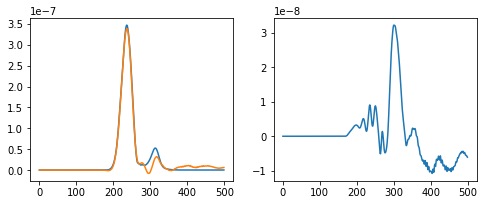

In [81]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(read_su('results_fwd/denv_Shot0001.su'))
plt.plot(read_su('results/RE0_Shot0001.su'))
plt.subplot(1,2,2)
plt.plot(read_su('results/RdE_Shot0001.su'))

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(read_su('results_fwd/denv_Shot0001.su'))
plt.plot(read_su('results/RE0_Shot0001.su')+artifical*read_su('results/RdE_Shot0001.su'))
plt.subplot(1,2,2)
plt.plot(read_su('results/dadj_Shot0001.su'))

In [88]:
!cp setup.in setup_test.in
!echo "FILE_WAVELET   './results_wl/muted_updated_wavelet.su'" >> setup_test.in
!echo "JOB   'build tilD'" >> setup_test.in
!echo "ALPHAS     '1e-8 1e-7 1e-6 1e-5 1e-4'" >> setup_test.in
!echo "ARTIFICIAL_SCALER_ON_dE     1e-3" >> setup_test.in

!rm -r results
!../../exe/GradientTest  setup_test.in > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond
 1st cond   9.99999994E-09  0.317615151      0.317615151       0.00000000      -256.628357            -Infinity T
 1st cond   1.00000001E-07  0.323447853      0.317615151       58327.0195      -256.628357      -4.39981930E-03 F
 1st cond   9.99999997E-07  0.315948427      0.317615151      -1666.72473      -256.628357      0.153971657     T
 1st cond   9.99999975E-06  0.295547426      0.317615151      -2206.77271      -256.628357      0.116291247     T
 1st cond   9.99999975E-05   8.04568863      0.317615151       77280.7344      -256.628357      -3.32072866E-03 F


## PFEI gradient for vp2

In [ ]:
# plt.plot(read_su('results_wl/wavelet.su'))
# plt.plot(read_su('results_wl/updated_wavelet.su'))
# plt.plot(read_su('results_wl/muted_updated_wavelet.su'))
# suximage < results_grad/RE0_Shot0001.su clip=1e-5 &
# suximage < results_grad/RdE_Shot0001.su clip=1e-5 &
# susum  results_grad/RE0_Shot0001.su  results_grad/RdE_Shot0001.su | suximage clip=1e-5 &
#
# ximage < results_grad/gvp2_F1_star_E0 title=gvp2_F1_star_E0 n1=101 clip=1e-19 &
# ximage < results_grad/gvp2_F2_star_dE title=gvp2_F2_star_dE n1=101 clip=1e-19 &
# ximage < results_grad/gvp2_F2_star_E0 title=gvp2_F2_star_E0 n1=101 clip=1e-19 &